# Predicting MIDI drum performance style and drummer

Data is from here: https://magenta.tensorflow.org/datasets/groove

Here's the overview of predicting style and drummer of MIDI drum performances:

1. Find maximum and minimum values of all note velocities in the training dataset.
2. Divide the range between min and max value into N bins.
3. For each MIDI file, count how many note velocities fall into each bin and normalize.
4. Use normalized bin values as features for classification.

In [35]:
import pandas as pd

dataset_folder = "groove-MIDI-dataset"

df = pd.read_csv(f"{dataset_folder}/info.csv")
df.head()

,drummer,session,id,style,bpm,beat_type,time_signature,midi_filename,audio_filename,duration,split
0,drummer1,drummer1/eval_session,drummer1/eval_session/1,funk/groove1,138,beat,4-4,drummer1/eval_session/1_funk-groove1_138_beat_...,drummer1/eval_session/1_funk-groove1_138_beat_...,27.872308,test
1,drummer1,drummer1/eval_session,drummer1/eval_session/10,soul/groove10,102,beat,4-4,drummer1/eval_session/10_soul-groove10_102_bea...,drummer1/eval_session/10_soul-groove10_102_bea...,37.691158,test
2,drummer1,drummer1/eval_session,drummer1/eval_session/2,funk/groove2,105,beat,4-4,drummer1/eval_session/2_funk-groove2_105_beat_...,drummer1/eval_session/2_funk-groove2_105_beat_...,36.351218,test
3,drummer1,drummer1/eval_session,drummer1/eval_session/3,soul/groove3,86,beat,4-4,drummer1/eval_session/3_soul-groove3_86_beat_4...,drummer1/eval_session/3_soul-groove3_86_beat_4...,44.716543,test
4,drummer1,drummer1/eval_session,drummer1/eval_session/4,soul/groove4,80,beat,4-4,drummer1/eval_session/4_soul-groove4_80_beat_4...,drummer1/eval_session/4_soul-groove4_80_beat_4...,47.987500,test


## Feature extraction

We need to find the minimum and maximum note velocity across the entire training dataset.

In [36]:
import pretty_midi as pm

def min_max_velocity(midi_files: list[str])-> tuple[float, float]:
    min_velocity = 1000000.0
    max_velocity = -1.0
    
    for file_name in midi_files:
        midi_data = pm.PrettyMIDI(file_name)
        velocities = [
            note.velocity 
            for note in midi_data.instruments[0].notes
        ]
        min_velocity = min(min_velocity, min(velocities))
        max_velocity = max(max_velocity, max(velocities))
    
    return min_velocity, max_velocity

The range between minimum and maximum velocity could be divided into a fixed number of bins. With these bins, we can create a histogram of note velocity values. The height of each bin (between 0 and 1) will become to one element of a feature vector for classification.

In [37]:
def get_bin_names(n_bins: int) -> list[str]:
    return [
        f"bin_{i}" 
        for i in range(1, n_bins + 1)
    ]

In [38]:
def get_velocity_bins(midi_file: str,
                      min_velocity: float,
                      max_velocity: float,
                      n_bins: int) -> dict[str, float]:
    
    midi_data = pm.PrettyMIDI(midi_file)
    bins = get_bin_names(n_bins)

    result = { bin: 0.0 for bin in bins }
    bin_width = (max_velocity - min_velocity) / n_bins

    notes = midi_data.instruments[0].notes

    for note in notes:
        velocity = note.velocity
        for i in range(n_bins):
            if velocity <= min_velocity + (i+1)*bin_width:
                result[bins[i]] += 1
                break
    
    for bin in result:
        result[bin] /= len(notes)
    
    return result

## Exploratory data analysis

The dataset gives us primary and secondary style in the form `primary/secondary`, but for simplicity we only use the primary style.

In [39]:
df = pd.read_csv(f"{dataset_folder}/info.csv")
df = df[["midi_filename", "style", "drummer"]]
df["style"] = df["style"].str.split("/").str.get(0)
df.head()

,midi_filename,style,drummer
0,drummer1/eval_session/1_funk-groove1_138_beat_...,funk,drummer1
1,drummer1/eval_session/10_soul-groove10_102_bea...,soul,drummer1
2,drummer1/eval_session/2_funk-groove2_105_beat_...,funk,drummer1
3,drummer1/eval_session/3_soul-groove3_86_beat_4...,soul,drummer1
4,drummer1/eval_session/4_soul-groove4_80_beat_4...,soul,drummer1


First let's visualise class distribution in the training dataset.

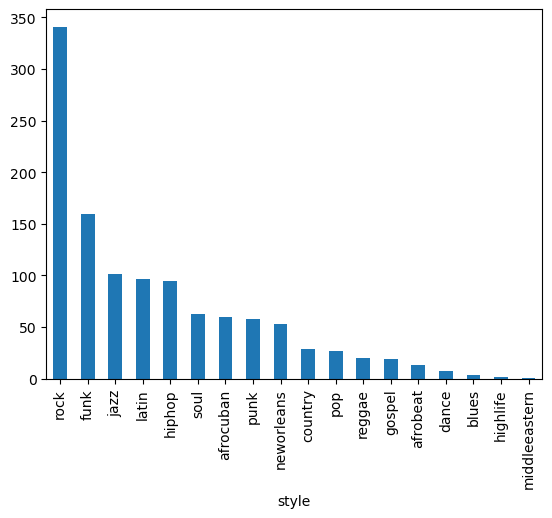

In [40]:
import matplotlib.pyplot as plt

value_counts = df['style'].value_counts()
value_counts.plot(kind='bar')
plt.show()

Let's choose only the most frequent styles in the dataset.

In [7]:
chosen_styles = ["rock", "funk", "jazz", "latin", "hiphop"]

Let's do the same for drummers.

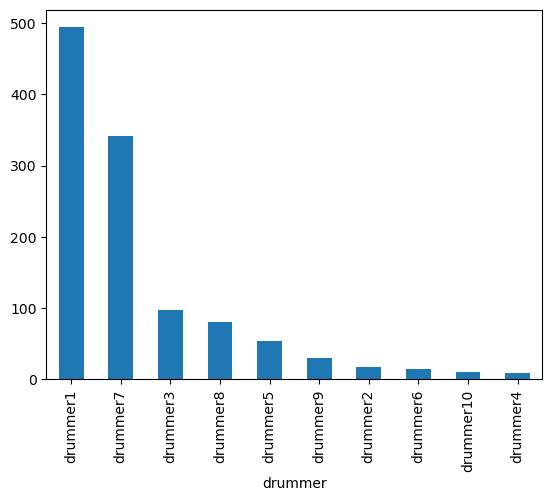

In [41]:
value_counts = df['drummer'].value_counts()
value_counts.plot(kind='bar')
plt.show()

In [42]:
chosen_drummers = ["drummer1", "drummer7", "drummer3"]

## Data preproccessing

In [43]:
import random

def preproccess(data: pd.DataFrame, 
                target_feature: str,
                chosen_classes: list[str],
                n_bins: int):
    
    df = data[
        data[target_feature].isin(chosen_classes)
    ].copy()

    # Let's ignore the "split" provided by the dataset.
    n_train = int(0.8*len(df))
    split_classes = ["train"] * n_train + ["test"] * (len(df) - n_train)
    random.seed(0)
    random.shuffle(split_classes)
    df["split"] = split_classes

    train_df = df[df["split"] == "train"]
    train_midi_files = [
        f"{dataset_folder}/{file_name}" 
        for file_name in train_df["midi_filename"]
    ]

    min_velocity, max_velocity = min_max_velocity(train_midi_files)

    def create_velocity_bins(row):
        midi_file = f"{dataset_folder}/{row['midi_filename']}"

        return pd.Series(get_velocity_bins(
            midi_file, min_velocity, max_velocity, n_bins
        ))
    
    bin_cols = df.apply(create_velocity_bins, axis=1)
    return pd.concat([df[[target_feature, "split"]], bin_cols], axis=1), min_velocity, max_velocity

Now we can prepare two datasets: one for predicting style and the other for predicting the drummer.

In [44]:
style_data, min_velocity, max_velocity = preproccess(
    data=df, 
    target_feature="style", 
    chosen_classes=chosen_styles,
    n_bins=10
)
drummer_data, _, _ = preproccess(
    data=df, 
    target_feature="drummer", 
    chosen_classes=chosen_drummers,
    n_bins=10
)
style_data.head()

,style,split,bin_1,bin_2,bin_3,bin_4,bin_5,bin_6,bin_7,bin_8,bin_9,bin_10
0,funk,train,0.002439,0.046341,0.163415,0.263415,0.204878,0.109756,0.104878,0.051220,0.039024,0.014634
2,funk,test,0.037152,0.074303,0.099071,0.123839,0.188854,0.142415,0.133127,0.055728,0.065015,0.080495
5,funk,train,0.016304,0.081522,0.198370,0.201087,0.312500,0.130435,0.040761,0.016304,0.000000,0.002717
6,hiphop,train,0.027473,0.085165,0.175824,0.104396,0.184066,0.134615,0.120879,0.071429,0.041209,0.054945
8,rock,train,0.004425,0.004425,0.030973,0.066372,0.035398,0.079646,0.234513,0.194690,0.137168,0.212389


Lets visualize one of the velocity histograms from style dataset.

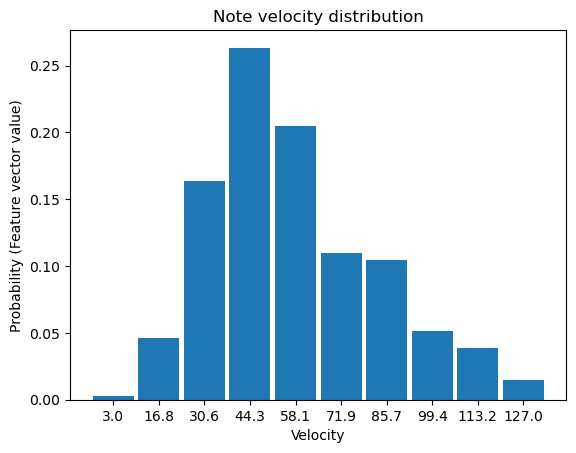

In [45]:
import numpy as np
import matplotlib.pyplot as plt

bin_names = get_bin_names(10)
x_values = np.linspace(min_velocity, max_velocity, 10)
y_values = style_data.loc[0][bin_names]
bar_width = (max_velocity - min_velocity)/10

plt.bar(x_values, y_values, width=bar_width)
plt.xticks(x_values)
plt.title("Note velocity distribution")
plt.xlabel("Velocity")
plt.ylabel("Probability (Feature vector value)")
plt.show()

## Training utility functions

In [46]:
def split_data(df: pd.DataFrame, 
               n_bins: int,
               target_feature: str):
    bin_names = get_bin_names(n_bins)
    train_df = df[df["split"] == "train"]
    test_df = df[df["split"] == "test"]

    return {
        "train_X": train_df[bin_names], 
        "train_Y": train_df[target_feature],
        "test_X": test_df[bin_names],
        "test_Y": test_df[target_feature]
    }

This function trains a given classifier model and plots confusion matrix based on test dataset. Each row of the confusion matrix is normalized.

In [47]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder


def plot_confusion_matrix(split_data, classifier):
    label_enc = LabelEncoder()
    enc_train_Y = label_enc.fit_transform(split_data["train_Y"])
    enc_test_Y = label_enc.transform(split_data["test_Y"])

    trained_clf = classifier.fit(
        split_data["train_X"], 
        enc_train_Y
    )
    
    ConfusionMatrixDisplay.from_estimator(
        estimator=trained_clf,
        X = split_data["test_X"],
        y = enc_test_Y,
        normalize = "true",
        cmap = "magma",
        include_values = False,
        labels = trained_clf.classes_,
        display_labels=label_enc.classes_,
        xticks_rotation = "vertical"
    )

## Style prediction

In [48]:
style_data_split = split_data(style_data, 10, "style")

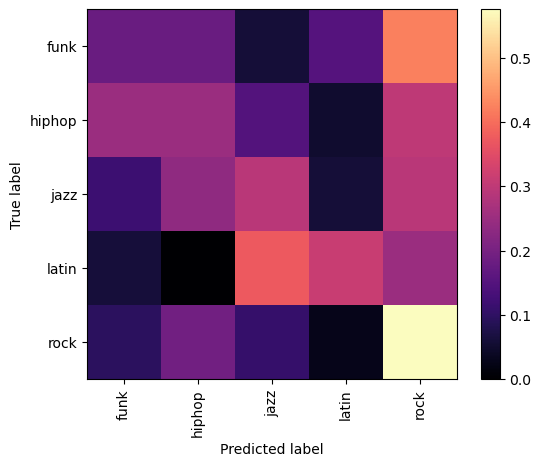

In [49]:
from sklearn.tree import DecisionTreeClassifier

plot_confusion_matrix(
    style_data_split,
    DecisionTreeClassifier()
)

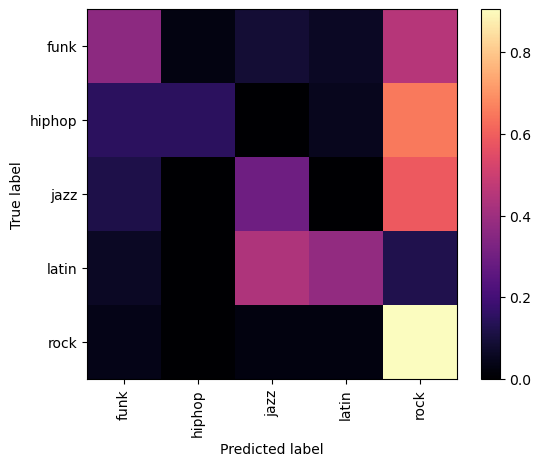

In [50]:
from sklearn.ensemble import RandomForestClassifier

plot_confusion_matrix(
    style_data_split,
    RandomForestClassifier()
)

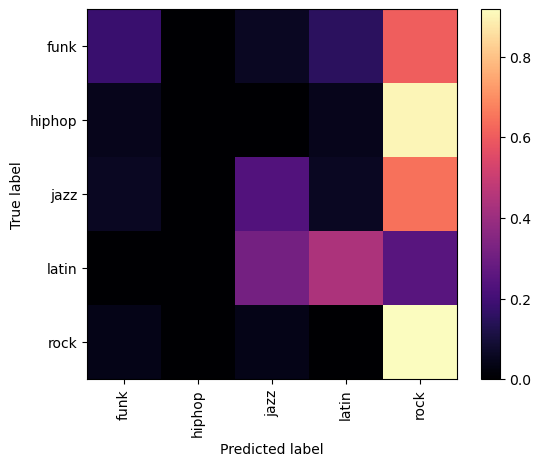

In [51]:
from sklearn.svm import SVC

plot_confusion_matrix(
   style_data_split, SVC()
)

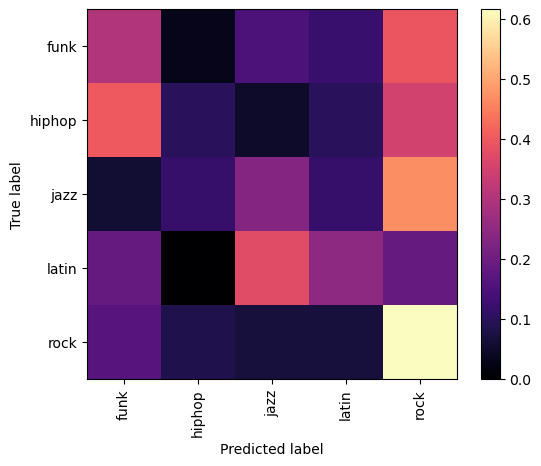

In [52]:
from sklearn.neighbors import KNeighborsClassifier

plot_confusion_matrix(
    style_data_split,
    KNeighborsClassifier()
)

## Drummer prediction

In [53]:
drummer_data_split = split_data(drummer_data, 10, "drummer")

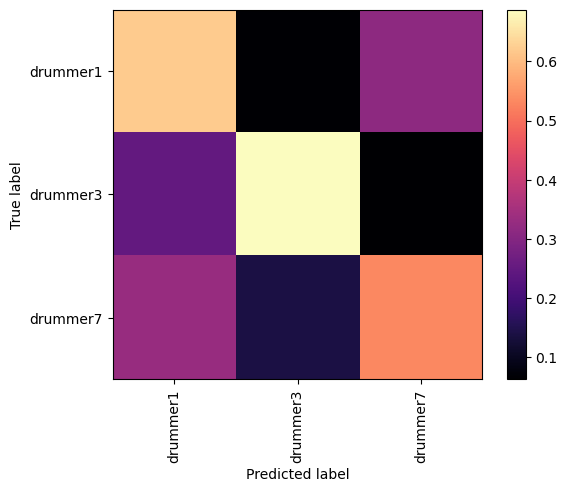

In [54]:
from sklearn.tree import DecisionTreeClassifier

plot_confusion_matrix(
    drummer_data_split,
    DecisionTreeClassifier()
)

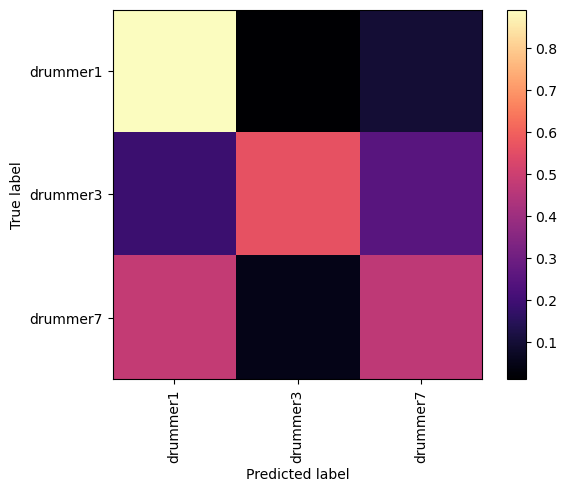

In [55]:
from sklearn.ensemble import RandomForestClassifier

plot_confusion_matrix(
    drummer_data_split,
    RandomForestClassifier()
)

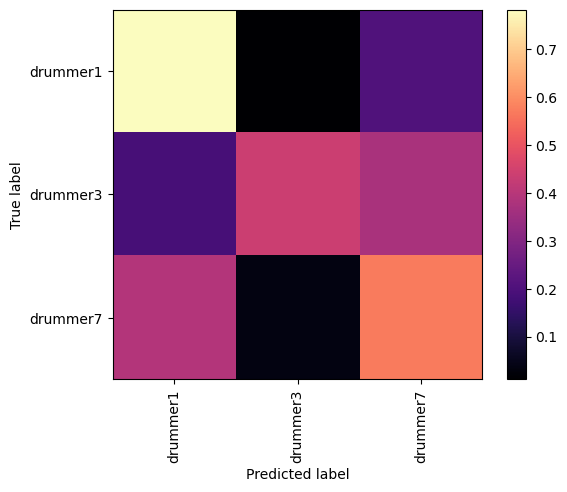

In [56]:
from sklearn.svm import SVC

plot_confusion_matrix(
    drummer_data_split, SVC()
)

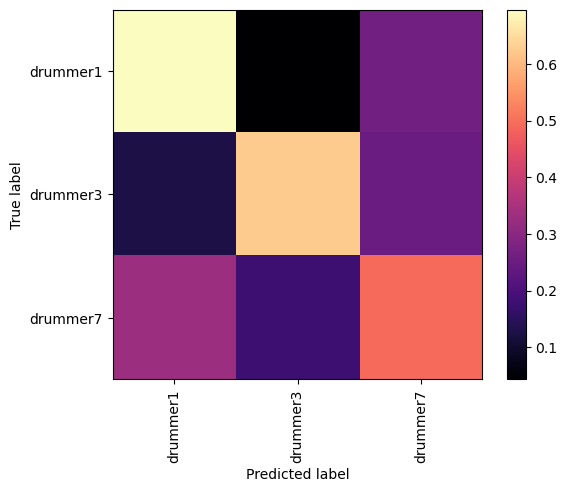

In [57]:
from sklearn.neighbors import KNeighborsClassifier

plot_confusion_matrix(
    drummer_data_split,
    KNeighborsClassifier()
)

## Conclusion

For drummer prediction, `DecisionTreeClassifier` and `KNeighborsClassifier` are more successful than `RandomForestClassifier` and `SVC`. Style prediction seems to be less successful.